In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE)

plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# To plot pretty figures
%matplotlib inline

# Credit Card Dataset

In [267]:
data_train = pd.read_csv("data/credit_train_reduced.csv", index_col=0)
data_test = pd.read_csv("data/credit_test_reduced.csv", index_col=0)

X_train = data_train.drop(data_train.columns[-1],axis=1)
y_train = data_train.iloc[:,-1]

X_test = data_test.drop(data_test.columns[-1],axis=1)
y_test = data_test.iloc[:,-1]
data_train.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
V1,,,,,,,,,,,,,,,,,,,,,
1.114107,0.188459,0.149144,1.153868,0.224011,0.396246,0.020168,0.217603,-0.141379,0.090719,1.428138,...,-0.255692,0.065655,0.367010,-0.090954,-0.271464,0.646597,-0.217493,0.035881,-0.004553,0
1.910941,0.686774,-0.595770,3.817385,0.288991,-0.660187,0.365387,-0.261102,-1.226056,1.527476,-0.610363,...,-0.282781,0.266636,0.805442,0.114189,0.401013,0.069967,0.108304,-0.039724,-0.047338,0
0.013514,0.452287,-0.738086,-0.950309,1.405159,-0.423082,1.115085,-0.073982,-0.349808,-0.362877,-0.163693,...,-0.146694,0.152423,0.411430,-0.017938,0.227643,-0.857711,0.444818,0.136231,0.229043,0
-1.273388,0.270815,1.256719,1.064659,-1.401545,0.234430,1.194255,0.412955,-0.528987,-1.038559,-0.228716,...,0.472001,0.407454,0.673393,0.759378,0.580046,-0.310258,-0.463227,-0.023899,0.134970,0
1.978615,0.114560,-1.322450,0.577586,0.348417,-0.376863,-0.211046,-0.123861,1.623757,-0.637724,2.307537,...,-0.137539,-0.138925,-0.031185,0.191191,0.598530,-0.182579,0.389251,-0.075180,-0.040764,0


In [298]:
# X = raw_data.drop(columns=["Class"])
# y = raw_data["Class"].copy()

inlier_train = X_train[y_train==0]
inlier_test = X_test[y_test==0]
outliers = X_test[y_test==1]
outliers_all = np.concatenate((outliers, X_train[y_train==1]))

# ## No need to split again
# outliers = X[y==1]
# outlier_ratio = len(outliers) / len(X)

# # Test samples of non-anomalous class are the same size as outliers
# test_ratio = outlier_ratio
# splitter = ShuffleSplit(n_splits=1, test_size=test_ratio)

# for train_index,test_index in splitter.split(inliers):
#     inlier_train = inliers.iloc[train_index]
#     inlier_test = inliers.iloc[test_index]

# scaler = StandardScaler()

# inlier_train = scaler.fit_transform(inlier_train)
# inlier_test = scaler.transform(inlier_test)
# outliers = scaler.transform(outliers)

In [269]:
%%time
GMM = GaussianMixture(n_components=3, covariance_type="full")
GMM.fit(inlier_train)

CPU times: user 3.08 s, sys: 48.7 ms, total: 3.13 s
Wall time: 803 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [270]:
print("Training Likelihood: {:.3f}".format(GMM.score(inlier_train)))

Training Likelihood: -16.787


In [271]:
print("Testing Likelihood: {:.3f}".format(GMM.score(X_test)))

Testing Likelihood: -89.576


In [272]:
print("Testing Likelihood: {:.3f}".format(GMM.score(inlier_test)))
print("Outlier Likelihood: {:.3f}".format(GMM.score(outliers)))

Testing Likelihood: -18.247
Outlier Likelihood: -4228.807


In [273]:
print("Testing BIC: {:.3f}".format(GMM.bic(inlier_test)))
print("Outlier BIC: {:.3f}".format(GMM.bic(outliers)))

Testing BIC: 218064.714
Outlier BIC: 834426.135


## This is weighted probability of each sample occuring from this distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1fc12c88>]],
      dtype=object)

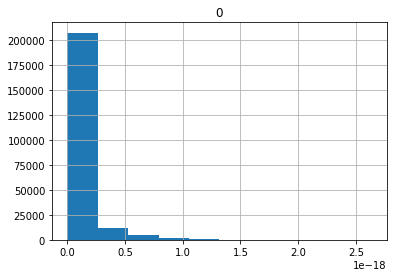

In [51]:
scores = pd.DataFrame(np.exp(GMM.score_samples(inlier_train)))
scores.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20e17ac8>]],
      dtype=object)

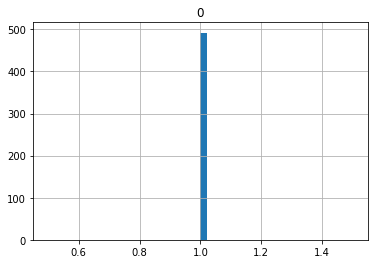

In [50]:
outlier_probs = pd.DataFrame(GMM.predict_proba(outliers))
outlier_probs.hist(bins=50)

## Gridsearch to get better density estimation...

In [283]:
%%time
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(inlier_train)
        bic.append(gmm.bic(inlier_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

CPU times: user 6min 59s, sys: 4.09 s, total: 7min 3s
Wall time: 1min 46s


In [284]:
best_gmm

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=19, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

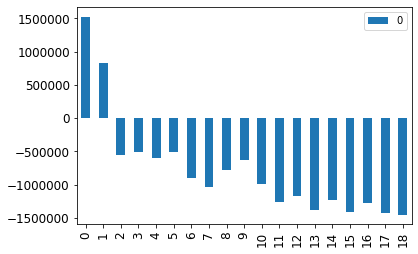

In [287]:
bics = pd.DataFrame(bic)
bics.plot(kind="bar")

In [288]:
%%time
best_gmm = GaussianMixture(n_components=19, covariance_type="full", max_iter=100, n_init=5)
best_gmm.fit(inlier_train)

CPU times: user 3min 22s, sys: 1.9 s, total: 3min 24s
Wall time: 51.8 s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=19, n_init=5,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [289]:
print("Training Likelihood: {:.3f}".format(best_gmm.score(inlier_train)))
print("Testing Likelihood: {:.3f}".format(best_gmm.score(inlier_test)))
print("Outlier Likelihood: {:.3f}".format(best_gmm.score(outliers)))

Training Likelihood: 34.720
Testing Likelihood: 32.459
Outlier Likelihood: -2761.098


## Its possible to visualize posterior probabilities 

In [290]:
# outlier_probs = pd.DataFrame(best_gmm.predict_proba(outliers))
# outlier_probs.hist(bins=5, figsize=(16,8))

## Recall that score samples returns probability *densities*
> In order to use them we have to integrate from 0 to x

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a51d323c8>]],
      dtype=object)

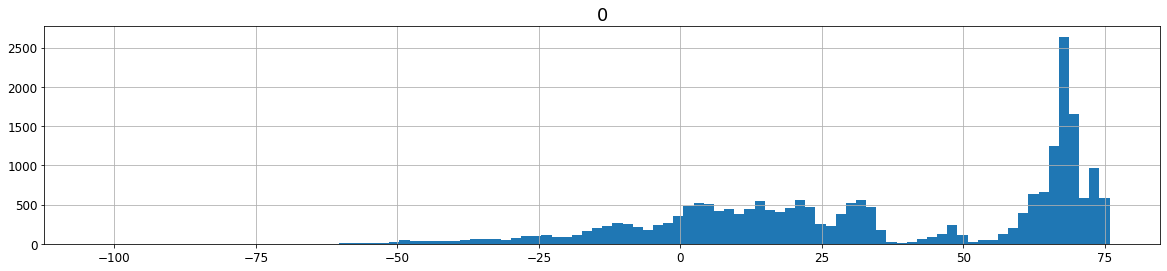

In [291]:
train_scores = pd.DataFrame(best_gmm.score_samples(inlier_train))
train_scores.hist(bins=100, figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a51d81cf8>]],
      dtype=object)

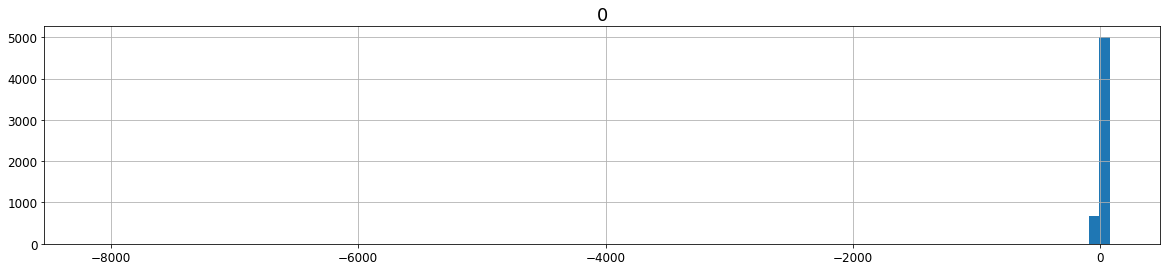

In [292]:
test_scores = pd.DataFrame(best_gmm.score_samples(inlier_test))
test_scores.hist(bins=100, figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a52173e48>]],
      dtype=object)

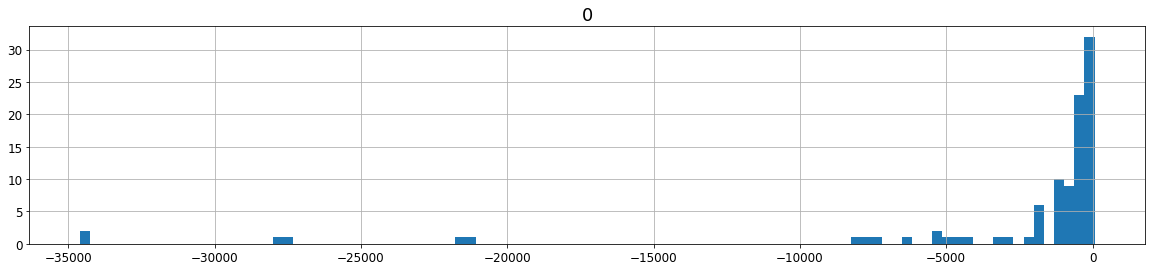

In [293]:
outlier_scores = pd.DataFrame(best_gmm.score_samples(outliers))
outlier_scores.hist(bins=100, figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a52963518>]],
      dtype=object)

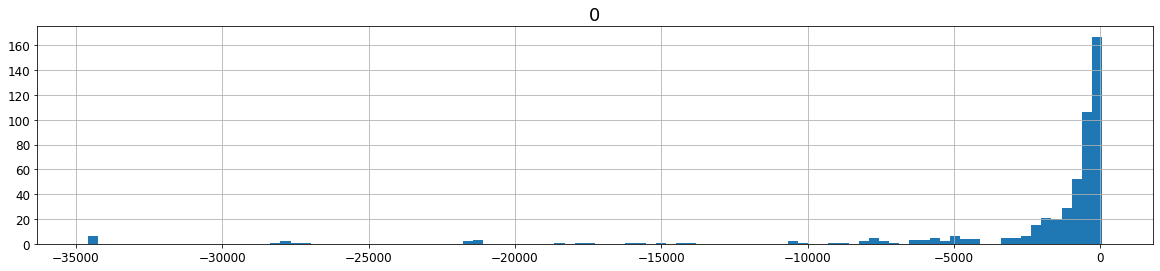

In [299]:
outlier_scores_all = pd.DataFrame(best_gmm.score_samples(outliers_all))
outlier_scores_all.hist(bins=100, figsize=(20,4))

In [295]:
test_scores.quantile(0.1)

0   -9.838579
Name: 0.1, dtype: float64

In [300]:
from sklearn.metrics import classification_report as report

thresh = test_scores.mean()[0] #test_scores.quantile(0.01)[0]
y_probs = np.concatenate((test_scores, outlier_scores_all))
y_true = np.concatenate(([0]*len(test_scores), [1]*len(outlier_scores_all)))
y_pred = y_probs < thresh
print(report(y_true, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.98669   0.49534   0.65956      5687
           1    0.13658   0.92276   0.23795       492

    accuracy                        0.52937      6179
   macro avg    0.56164   0.70905   0.44875      6179
weighted avg    0.91900   0.52937   0.62599      6179



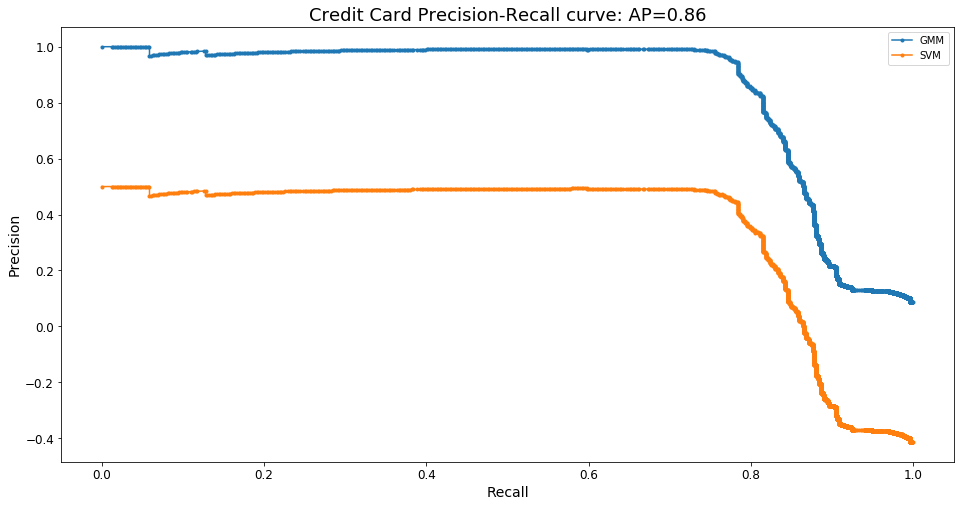

In [309]:
## Getting Precision Recall Curves
credit_prec, credit_recall, threshes = precision_recall_curve(y_true, -y_probs)
credit_avg_prec = average_precision_score(y_true, -y_probs)

plt.figure(figsize=(16, 8))
plt.plot(credit_recall, credit_prec, marker='.', label='GMM')
# plt.plot(credit_recall, credit_prec-0.5, marker='.', label='SVM')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Credit Card Precision-Recall curve: '
                   'AP={0:0.2f}'.format(credit_avg_prec))
plt.legend()

In [64]:
print(y_pred.shape)
y_true.shape

(4414, 1)


(984,)

In [66]:
y_probs.shape

(984, 1)

## Using Average Precision to test different thresholds

In [129]:
# thresh = inlier_test.mean() + inlier_test.std()*3
y_score = np.concatenate((test_scores, outlier_scores))
y_true = np.concatenate(([0]*len(test_scores), [1]*len(outlier_scores)))

average_precision_score(y_true, y_score)

0.3137928530365953

# HTTP Dataset

In [118]:
data_train = pd.read_csv("data/http_train.csv", index_col=None)
data_test = pd.read_csv("data/http_test.csv", index_col=None)

X_train = data_train.drop(data_train.columns[-1],axis=1)
y_train = data_train.iloc[:,-1]

X_test = data_test.drop(data_test.columns[-1],axis=1)
y_test = data_test.iloc[:,-1]
data_train.head()

,0,1,2,3
0,-2.302585,5.638710,6.853405,0
1,-2.302585,5.727173,7.099284,0
2,-2.302585,5.204556,8.565431,0
3,-2.302585,5.333202,7.319269,0
4,-2.302585,5.464255,7.368403,0


In [119]:
inlier_train = X_train[y_train==0]
inlier_test = X_test[y_test==0]
outliers = X_test[y_test==1]
# outliers_all = np.concatenate((outliers, X_train[y_train==1]))

## Gridsearch to get better density estimation...

In [45]:
%%time
lowest_bic = np.infty
bic = []
n_components_range = range(1, 12)
cv_types = ['full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(inlier_train)
        bic.append(gmm.bic(inlier_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

CPU times: user 15min 25s, sys: 43.2 s, total: 16min 9s
Wall time: 4min 8s


In [ ]:
# n_components_range = range(1,8)
# param_grid = {'n_components': n_components_range}
# cv_test= KFold(n_splits=10)
# # class_weight='balanced' makes the result worse
# grid_search = GridSearchCV(GaussianMixture(n_init=3), param_grid, cv=cv_test, 
#                            scoring='average_precision', n_jobs=4)

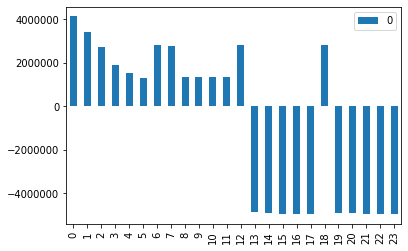

In [14]:
bics = pd.DataFrame(bic)
bics.plot(kind="bar")

In [120]:
%%time
best_gmm = GaussianMixture(n_components=3, covariance_type="full", n_init=3)
best_gmm.fit(inlier_train)

CPU times: user 13.4 s, sys: 427 ms, total: 13.8 s
Wall time: 3.82 s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=3, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [121]:
print("Training Likelihood: {:.3f}".format(best_gmm.score(inlier_train)))
print("Testing Likelihood: {:.3f}".format(best_gmm.score(inlier_test)))
print("Outlier Likelihood: {:.3f}".format(best_gmm.score(outliers)))

Training Likelihood: 4.373
Testing Likelihood: 4.380
Outlier Likelihood: -23.895


## Recall that score samples returns probability *densities*
> In order to use them we have to integrate from 0 to x

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3493cb00>]],
      dtype=object)

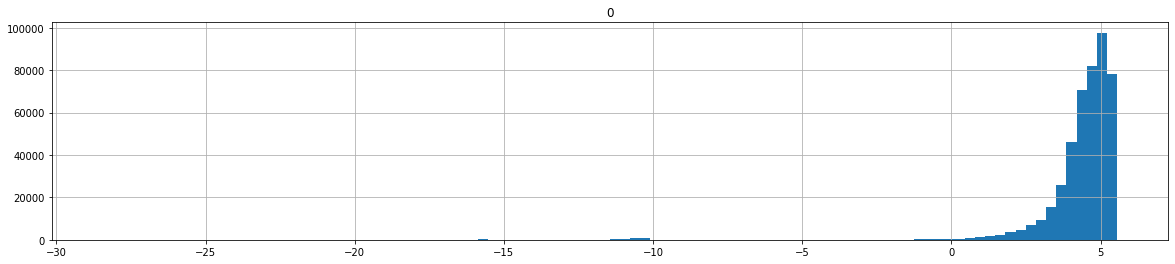

In [122]:
train_scores = pd.DataFrame(best_gmm.score_samples(inlier_train))
train_scores.hist(bins=100, figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3497a860>]],
      dtype=object)

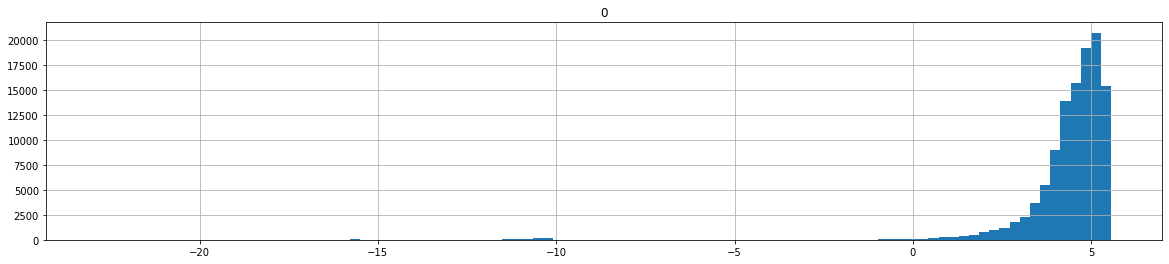

In [123]:
test_scores = pd.DataFrame(best_gmm.score_samples(inlier_test))
test_scores.hist(bins=100, figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3449f048>]],
      dtype=object)

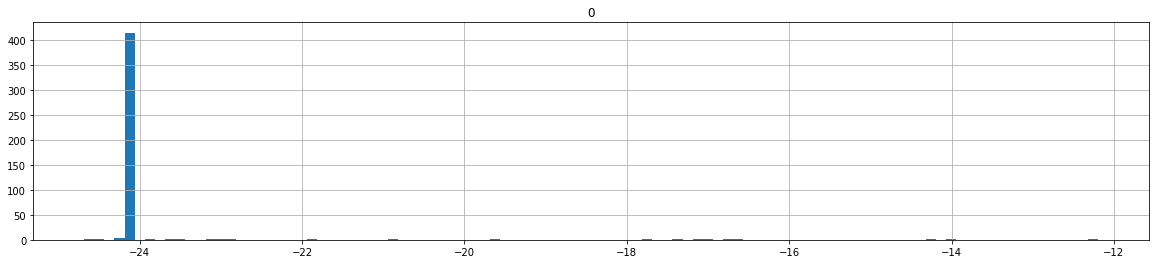

In [124]:
epsilon = 1e-10
outlier_scores = pd.DataFrame(best_gmm.score_samples(outliers))
outlier_scores.hist(bins=100, figsize=(20,4))

## Using Average Precision to test different thresholds

In [125]:
len(outlier_scores)

442

In [144]:
##### thresh = (test_scores.mean() - test_scores.std()*3)[0]

thresh = -20 #test_scores.quantile(0.001)[0]
test_data = np.concatenate([inlier_test, outliers])
y_probs = np.concatenate((test_scores, outlier_scores))

y_true = np.concatenate(([0]*len(test_scores), [1]*len(outlier_scores)))
y_pred = y_probs < thresh

print(report(y_true, y_pred,digits=5))

              precision    recall  f1-score   support

           0    0.99989   0.99989   0.99989    113058
           1    0.97279   0.97059   0.97169       442

    accuracy                        0.99978    113500
   macro avg    0.98634   0.98524   0.98579    113500
weighted avg    0.99978   0.99978   0.99978    113500



In [145]:
http_avg_prec = average_precision_score(y_true, -y_probs)
print("Avg Prec: {:.4f}".format(avg_prec))

Avg Prec: 0.9968


Text(0.5, 1.0, 'HTTP Precision-Recall curve: AP=1.00')

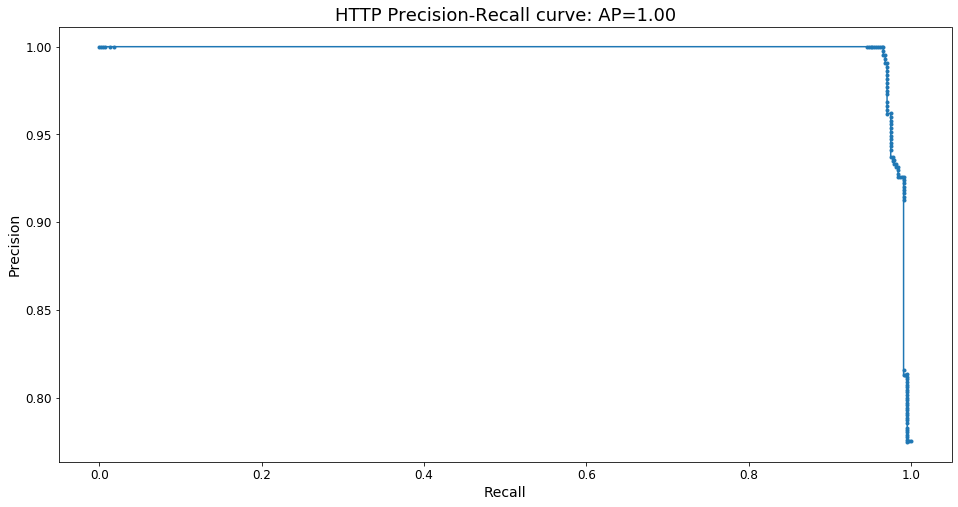

In [180]:
## Getting Precision Recall Curves
http_prec, http_recall, threshes = precision_recall_curve(y_true, -y_probs)

plt.figure(figsize=(16, 8))
plt.plot(http_recall, http_prec, marker='.', label='GMM')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('HTTP Precision-Recall curve: '
                   'AP={0:0.2f}'.format(http_avg_prec))

In [134]:
threshes

array([-24.68679479, -24.47751303, -24.24213207, ...,   5.55345876,
         5.55353969,   5.55354127])

# Cardio Dataset

In [243]:
data_train = pd.read_csv("data/cardio_train.csv", index_col=None)
data_test = pd.read_csv("data/cardio_test.csv", index_col=None)

X_train = data_train.drop(data_train.columns[-1],axis=1)
y_train = data_train.iloc[:,-1]

X_test = data_test.drop(data_test.columns[-1],axis=1)
y_test = data_test.iloc[:,-1]
data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-2.746331,0.674374,-0.203640,0.569296,-0.683598,-0.061401,-0.278295,1.161352,-0.862298,-0.420487,...,0.342006,-0.565334,-0.409388,-0.488279,-1.441887,-1.083848,-1.561651,-0.222985,-2.126605,0
1,-1.476526,-0.487369,-0.203640,0.159199,-0.127511,-0.061401,-0.278295,-1.171841,-0.051613,0.948799,...,-0.655829,-0.235325,-0.753395,2.414444,-0.600269,-0.828456,-0.940945,-0.323186,-0.493294,0
2,-0.312539,-0.380829,0.066072,-1.635871,-0.683598,-0.061401,-0.278295,0.144320,-0.630673,-0.420487,...,-1.368567,-0.455331,0.622631,-0.488279,-0.179460,0.001569,-0.182306,-0.556988,1.140018,0
3,-0.947441,3.464968,-0.203640,-0.961999,-0.683598,-0.061401,-0.278295,-1.231666,0.874885,-0.420487,...,0.342006,-0.675337,-1.097401,-0.488279,0.000886,0.001569,-0.113338,-0.523588,-0.493294,0
4,0.533997,-0.437880,-0.163445,0.697949,1.175504,-0.061401,-0.278295,0.802400,0.411636,-0.420487,...,-1.083472,0.094683,0.622631,-0.488279,0.181233,0.001569,0.300465,0.044218,1.140018,0


In [244]:
y_train.value_counts()

0    1323
1     141
Name: 21, dtype: int64

In [255]:
inlier_train = X_train[y_train==0]
inlier_test = X_test[y_test==0]
outliers = X_test[y_test==1]
outliers_all = np.concatenate((outliers, X_train[y_train==1]))

## Gridsearch to get better density estimation...

In [246]:
# %%time
# lowest_bic = np.infty
# bic = []
# n_components_range = range(1, 7)
# cv_types = ['full']
# for cv_type in cv_types:
#     for n_components in n_components_range:
#         # Fit a Gaussian mixture with EM
#         gmm = GaussianMixture(n_components=n_components,
#                               covariance_type=cv_type,
#                               n_init=5)
#         gmm.fit(inlier_train)
#         bic.append(gmm.bic(inlier_train))
#         if bic[-1] < lowest_bic:
#             lowest_bic = bic[-1]
#             best_gmm = gmm

In [247]:
%%time
best_gmm = GaussianMixture(n_components=10, covariance_type="full", max_iter=100, n_init=5)
best_gmm.fit(inlier_train)

CPU times: user 3.72 s, sys: 36.6 ms, total: 3.76 s
Wall time: 953 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=5,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [248]:
print("Training Likelihood: {:.3f}".format(best_gmm.score(inlier_train)))
print("Testing Likelihood: {:.3f}".format(best_gmm.score(inlier_test)))
print("Outlier Likelihood: {:.3f}".format(best_gmm.score(outliers)))

Training Likelihood: 15.601
Testing Likelihood: -259859.836
Outlier Likelihood: -4313008.128


## Recall that score samples returns probability *densities*
> In order to use them we have to integrate from 0 to x

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a45c3c860>]],
      dtype=object)

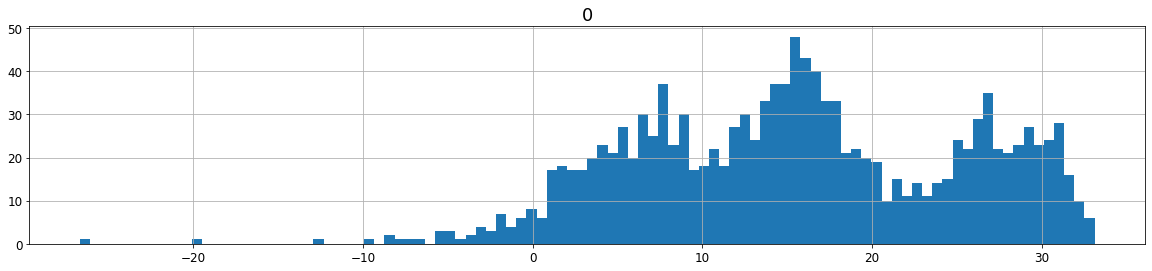

In [249]:
train_scores = pd.DataFrame(best_gmm.score_samples(inlier_train))
train_scores.hist(bins=100, figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4280ce48>]],
      dtype=object)

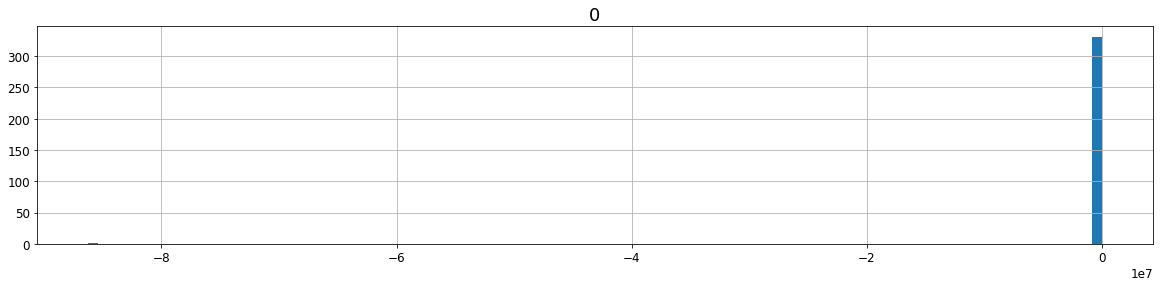

In [250]:
test_scores = pd.DataFrame(best_gmm.score_samples(inlier_test))
test_scores.hist(bins=100, figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a5dbd9b38>]],
      dtype=object)

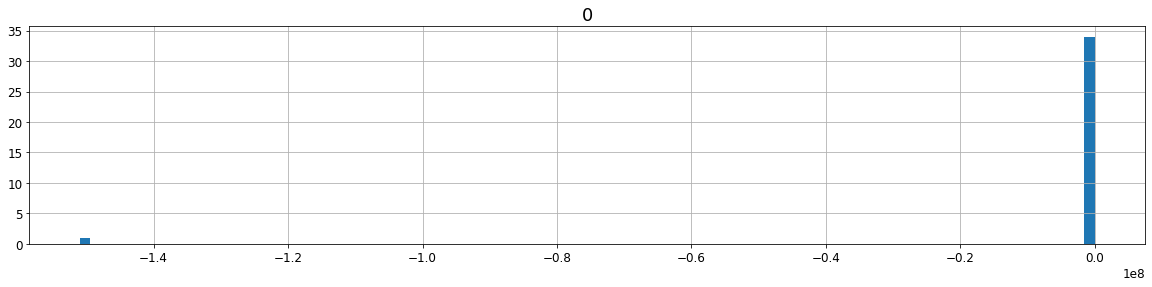

In [251]:
outlier_scores = pd.DataFrame(best_gmm.score_samples(outliers))
outlier_scores.hist(bins=100, figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a45c43208>]],
      dtype=object)

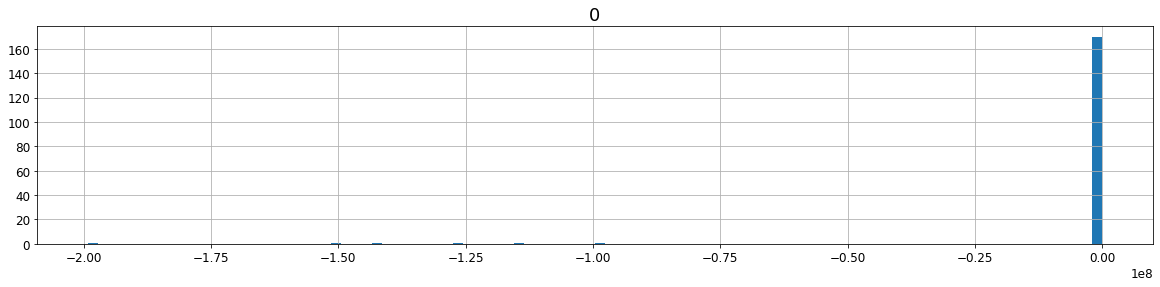

In [257]:
outlier_scores_all = pd.DataFrame(best_gmm.score_samples(outliers_all))
outlier_scores_all.hist(bins=100, figsize=(20,4))

## Using Average Precision to test different thresholds

In [262]:
test_scores.quantile(0.01)[0]

-40.01667648835267

In [263]:
# thresh = test_scores.mean() - test_scores.std()*4
thresh = test_scores.quantile(0.01)[0]
y_probs = np.concatenate((test_scores, outlier_scores_all))
y_true = np.concatenate(([0]*len(test_scores), [1]*len(outlier_scores_all)))
y_pred = y_probs < thresh

print(report(y_true, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.79227   0.98795   0.87936       332
           1    0.95745   0.51136   0.66667       176

    accuracy                        0.82283       508
   macro avg    0.87486   0.74966   0.77301       508
weighted avg    0.84950   0.82283   0.80567       508



In [264]:
avg_prec = average_precision_score(y_true, -y_probs)
print("Avg Prec: {:.4f}".format(avg_prec))

Avg Prec: 0.7995


Text(0.5, 1.0, 'HTTP Precision-Recall curve: AP=0.80')

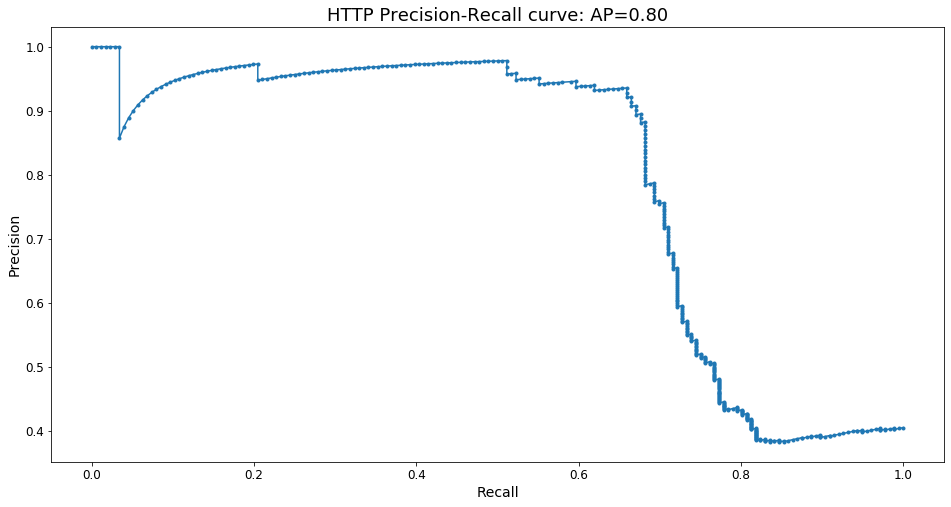

In [265]:
## Getting Precision Recall Curves

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
# from sklearn.metrics import plot_precision_recall_curve

cardio_prec, cardio_recall, threshes = precision_recall_curve(y_true, -y_probs)

plt.figure(figsize=(16, 8))
plt.plot(cardio_recall, cardio_prec, marker='.', label='GMM')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('HTTP Precision-Recall curve: '
                   'AP={0:0.2f}'.format(avg_prec))